# AFGROW Specimen Geometry Visualization

This notebook creates visualizations of fatigue specimen geometry based on the four parameters:
- **w/r**: Width ratio (specimen width W to hole center distance R)
- **R/t**: Hole thickness ratio (hole half-width R to specimen thickness t) 
- **a/t**: Crack height ratio (quarter-ellipse height a to specimen thickness t)
- **a/c**: Crack aspect ratio (quarter-ellipse height a to horizontal length c)

The specimen consists of:
1. Main rectangular specimen (width W, height t)
2. Vertical rectangular hole on the left side (width 2R)
3. Quarter-ellipse crack starting from bottom-left corner

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import pandas as pd

In [4]:
# Load the dataset
dataset_name = 'four_params_Kbearing_c'
data_array = np.load(f'../data/{dataset_name}.npy')

print(f"Dataset shape: {data_array.shape}")
print(f"Features: w_over_r, a_over_c, a_over_t, R_over_t")
print(f"Target: Kbearing_c")

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print("w/r\t\ta/c\t\ta/t\t\tR/t\t\tKbearing_c")
for i in range(5):
    row = data_array[i]
    print(f"{row[0]:.3f}\t\t{row[1]:.3f}\t\t{row[2]:.3f}\t\t{row[3]:.3f}\t\t{row[4]:.6f}")

# Feature indices
w_over_r_idx = 0
a_over_c_idx = 1  
a_over_t_idx = 2
R_over_t_idx = 3
Kbearing_c_idx = 4

Dataset shape: (92149, 5)
Features: w_over_r, a_over_c, a_over_t, R_over_t
Target: Kbearing_c

First 5 rows of the dataset:
w/r		a/c		a/t		R/t		Kbearing_c
4.600		0.100		0.100		0.400		0.911300
5.200		0.100		0.100		0.400		0.922500
5.800		0.100		0.100		0.400		0.931100
6.400		0.100		0.100		0.400		0.941300
7.000		0.100		0.100		0.400		0.953200


In [18]:
def plot_afgrow_specimen(w_over_r, a_over_c, a_over_t, R_over_t, specimen_height=10, title_suffix=""):
    """
    Plot AFGROW specimen geometry based on the four parameters
    
    Parameters:
    w_over_r: Width ratio (W/R)
    a_over_c: Crack aspect ratio (a/c)  
    a_over_t: Crack height ratio (a/t)
    R_over_t: Hole thickness ratio (R/t)
    specimen_height: Base height for visualization (default: 10)
    title_suffix: Additional text for plot title
    """
    
    # Set specimen thickness (height)
    t = specimen_height
    
    # Calculate actual dimensions from ratios
    R = R_over_t * t  # Hole half-width
    W = w_over_r * R  # Distance from left edge to hole center
    # If hole is grounded to left edge, hole center is at R, so W should equal R
    # But the ratio w/r suggests W can be different from R
    # Let's keep W as the distance to hole center for the ratio calculation
    total_specimen_width = W + R  # Total specimen width = distance to hole center + hole half-width
    a = a_over_t * t  # Crack vertical height
    c = a / a_over_c  # Crack horizontal length
    
    print(f"Calculated dimensions:")
    print(f"Hole center distance: W={W:.2f}, Hole half-width: R={R:.2f}")
    print(f"Total specimen width: {total_specimen_width:.2f}, Specimen height: t={t:.2f}")
    print(f"Width from hole center to right edge: {total_specimen_width - R:.2f}")
    print(f"Hole: R={R:.2f} (total hole width = {2*R:.2f})")
    print(f"Crack: a={a:.2f}, c={c:.2f} (starts at interface between hole and main specimen)")
    print(f"Crack position: ({2*R:.2f}, 0)")
    print(f"Note: W/R ratio = {w_over_r:.3f}")
    
    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # 0. Draw background specimen outline (for reference)
    background_rect = patches.Rectangle((0, 0), total_specimen_width, t, linewidth=1, edgecolor='gray', 
                                       facecolor='none', alpha=0.5, linestyle='--', label='Full Specimen Outline')
    ax.add_patch(background_rect)
    
    # 1. Draw vertical hole on the LEFT side of the specimen
    # Hole extends from x=0 to x=2R, y=0 to y=t (grounded to left edge)
    hole_rect = patches.Rectangle((0, 0), 2*R, t, linewidth=2, edgecolor='red', 
                                 facecolor='white', alpha=1.0, label='Vertical Hole')
    ax.add_patch(hole_rect)
    
    # 2. Draw main rectangular specimen (to the right of the hole)
    # The main specimen extends from x=2R to x=total_specimen_width, y=0 to y=t
    main_specimen_start = 2*R
    main_specimen_width = total_specimen_width - main_specimen_start
    main_rect = patches.Rectangle((main_specimen_start, 0), main_specimen_width, t, linewidth=3, edgecolor='black', 
                                 facecolor='lightblue', alpha=0.7, label='Main Specimen')
    ax.add_patch(main_rect)
    
    # 3. Draw quarter-ellipse crack from bottom-left corner of main specimen
    # Position crack at the interface between hole and main specimen (2R, 0)
    crack_center_x = 2*R  # At the interface between hole and main specimen
    crack_center_y = 0
    
    # Draw full ellipse for reference (lightly shaded unused quadrants)
    ellipse_full = Ellipse((crack_center_x, crack_center_y), 2*c, 2*a, linewidth=1, 
                          edgecolor='gray', facecolor='lightgray', alpha=0.2)
    ax.add_patch(ellipse_full)
    
    # Create quarter-ellipse crack (first quadrant only) - the actual crack
    # Since crack is at interface growing rightward and upward, use first quadrant (0 to pi/2)
    theta = np.linspace(0, np.pi/2, 100)  # First quadrant only
    crack_x = crack_center_x + c * np.cos(theta)
    crack_y = crack_center_y + a * np.sin(theta)
    ax.plot(crack_x, crack_y, 'r-', linewidth=4, label='Quarter-Ellipse Crack')
    
    # Fill the quarter-ellipse crack area
    crack_fill_x = np.concatenate([[crack_center_x], crack_x, [crack_center_x]])
    crack_fill_y = np.concatenate([[crack_center_y], crack_y, [crack_center_y]])
    ax.fill(crack_fill_x, crack_fill_y, color='red', alpha=0.3)
    
    # Shade out the unused three quadrants with hatching
    # Second quadrant (upper left)
    theta2 = np.linspace(np.pi/2, np.pi, 50)
    quad2_x = crack_center_x + c * np.cos(theta2)
    quad2_y = crack_center_y + a * np.sin(theta2)
    quad2_fill_x = np.concatenate([[crack_center_x], quad2_x, [crack_center_x]])
    quad2_fill_y = np.concatenate([[crack_center_y], quad2_y, [crack_center_y]])
    ax.fill(quad2_fill_x, quad2_fill_y, color='gray', alpha=0.4, hatch='///')
    
    # Third quadrant (lower left)
    theta3 = np.linspace(np.pi, 3*np.pi/2, 50)
    quad3_x = crack_center_x + c * np.cos(theta3)
    quad3_y = crack_center_y + a * np.sin(theta3)
    quad3_fill_x = np.concatenate([[crack_center_x], quad3_x, [crack_center_x]])
    quad3_fill_y = np.concatenate([[crack_center_y], quad3_y, [crack_center_y]])
    ax.fill(quad3_fill_x, quad3_fill_y, color='gray', alpha=0.4, hatch='///')
    
    # Fourth quadrant (lower right)
    theta4 = np.linspace(3*np.pi/2, 2*np.pi, 50)
    quad4_x = crack_center_x + c * np.cos(theta4)
    quad4_y = crack_center_y + a * np.sin(theta4)
    quad4_fill_x = np.concatenate([[crack_center_x], quad4_x, [crack_center_x]])
    quad4_fill_y = np.concatenate([[crack_center_y], quad4_y, [crack_center_y]])
    ax.fill(quad4_fill_x, quad4_fill_y, color='gray', alpha=0.4, hatch='///')
    
    # 4. Add dimension annotations
    # Total width annotation
    ax.annotate('', xy=(0, t+1), xytext=(total_specimen_width, t+1), 
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    ax.text(total_specimen_width/2, t+1.5, f'Total Width = {total_specimen_width:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # W distance annotation (from hole center to right edge of main specimen)
    specimen_width_from_center = total_specimen_width - R
    ax.annotate('', xy=(R, t+2.5), xytext=(total_specimen_width, t+2.5), 
                arrowprops=dict(arrowstyle='<->', color='blue', lw=2))
    ax.text((R + total_specimen_width)/2, t+3, f'W = {specimen_width_from_center:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='blue')
    
    # Height annotation
    ax.annotate('', xy=(total_specimen_width+1, 0), xytext=(total_specimen_width+1, t), 
                arrowprops=dict(arrowstyle='<->', color='black', lw=2))
    ax.text(total_specimen_width+1.5, t/2, f't = {t:.2f}', ha='left', va='center', fontsize=12, fontweight='bold', rotation=90)
    
    # Hole width annotation (grounded to left edge)
    ax.annotate('', xy=(0, -1), xytext=(2*R, -1), 
                arrowprops=dict(arrowstyle='<->', color='red', lw=2))
    ax.text(R, -1.5, f'2R = {2*R:.2f}', ha='center', va='top', fontsize=12, fontweight='bold', color='red')
    
    # Hole center line (now at R from left edge)
    ax.axvline(x=R, color='red', linestyle='--', alpha=0.7, linewidth=1)
    ax.text(R, t/2, 'Hole Center', ha='center', va='center', fontsize=10, rotation=90, 
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    # Crack dimensions (adjusted for position at interface between hole and main specimen)
    # For crack growing rightward and upward from interface
    ax.annotate('', xy=(crack_center_x, crack_center_y), xytext=(crack_center_x + c, crack_center_y), 
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.text(crack_center_x + c/2, crack_center_y - 0.5, f'c = {c:.2f}', ha='center', va='top', 
            fontsize=10, fontweight='bold', color='red')
    
    ax.annotate('', xy=(crack_center_x, crack_center_y), xytext=(crack_center_x, crack_center_y + a), 
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
    ax.text(crack_center_x - 0.5, crack_center_y + a/2, f'a = {a:.2f}', ha='right', va='center', 
            fontsize=10, fontweight='bold', color='red', rotation=90)
    
    # 5. Add parameter values as text
    param_text = f"Parameters:\nw/r = {w_over_r:.3f}\na/c = {a_over_c:.3f}\na/t = {a_over_t:.3f}\nR/t = {R_over_t:.3f}"
    ax.text(0.02, 0.98, param_text, transform=ax.transAxes, fontsize=11, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 6. Formatting
    ax.set_xlim(-2, total_specimen_width+3)
    ax.set_ylim(-3, t+4)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    title = f"AFGROW Specimen Geometry{title_suffix}"
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X-coordinate', fontsize=12)
    ax.set_ylabel('Y-coordinate', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

Visualizing sample 500:
w/r = 5.800
a/c = 0.800
a/t = 0.300
R/t = 0.100
Kbearing_c = 10.570000

Calculated dimensions:
Hole center distance: W=5.80, Hole half-width: R=1.00
Total specimen width: 6.80, Specimen height: t=10.00
Width from hole center to right edge: 5.80
Hole: R=1.00 (total hole width = 2.00)
Crack: a=3.00, c=3.75 (starts at interface between hole and main specimen)
Crack position: (2.00, 0)
Note: W/R ratio = 5.800


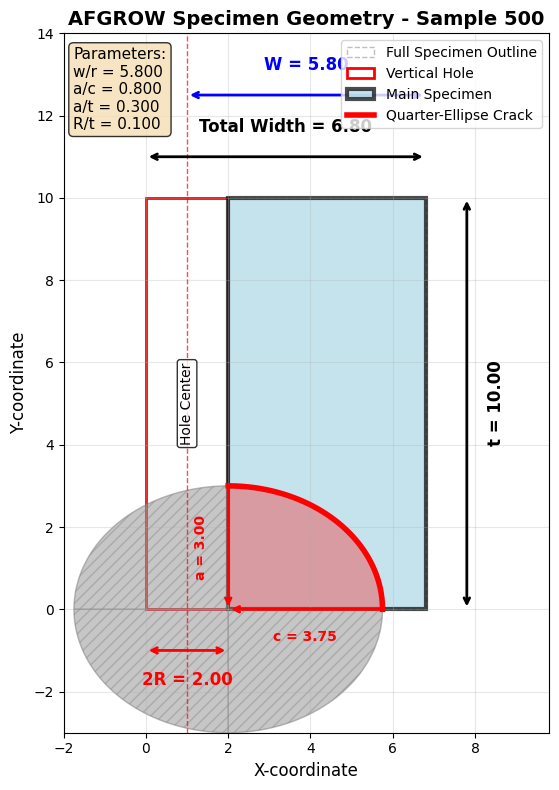

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'AFGROW Specimen Geometry - Sample 500'}, xlabel='X-coordinate', ylabel='Y-coordinate'>)

In [36]:
# Test the visualization with a sample from the dataset
sample_idx = 500  # Use first row
sample_data = data_array[sample_idx]

w_over_r = sample_data[w_over_r_idx]
a_over_c = sample_data[a_over_c_idx]
a_over_t = sample_data[a_over_t_idx]
R_over_t = sample_data[R_over_t_idx]

w_over_r, R_over_t, a_over_c, a_over_t = [5.8, 0.1, 0.8, 0.3]
Kbearing_c = sample_data[Kbearing_c_idx]

print(f"Visualizing sample {sample_idx}:")
print(f"w/r = {w_over_r:.3f}")
print(f"a/c = {a_over_c:.3f}")
print(f"a/t = {a_over_t:.3f}")
print(f"R/t = {R_over_t:.3f}")
print(f"Kbearing_c = {Kbearing_c:.6f}")
print()

# Create the visualization
plot_afgrow_specimen(w_over_r, a_over_c, a_over_t, R_over_t, 
                    title_suffix=f" - Sample {sample_idx}")

In [ ]:
# Interactive specimen selection - you can change the sample index here
def visualize_specimen_by_index(idx):
    """Visualize specimen geometry for a specific dataset index"""
    if idx >= len(data_array):
        print(f"Index {idx} is out of range. Dataset has {len(data_array)} samples.")
        return
    
    sample_data = data_array[idx]
    w_over_r = sample_data[w_over_r_idx]
    a_over_c = sample_data[a_over_c_idx]
    a_over_t = sample_data[a_over_t_idx]
    R_over_t = sample_data[R_over_t_idx]
    Kbearing_c = sample_data[Kbearing_c_idx]
    
    print(f"=== Specimen {idx} ===")
    print(f"Parameters: w/r={w_over_r:.3f}, a/c={a_over_c:.3f}, a/t={a_over_t:.3f}, R/t={R_over_t:.3f}")
    print(f"Stress Intensity Factor: Kbearing_c = {Kbearing_c:.6f}")
    print()
    
    plot_afgrow_specimen(w_over_r, a_over_c, a_over_t, R_over_t, 
                        title_suffix=f" - Sample {idx} (K={Kbearing_c:.4f})")

# Visualize several different specimens to see variety
specimen_indices = [0, 10, 50, 100, 500]  # You can change these indices

for idx in specimen_indices:
    if idx < len(data_array):
        visualize_specimen_by_index(idx)

In [ ]:
# Custom specimen visualization - specify your own parameters
def plot_custom_specimen():
    """Plot a specimen with custom parameters"""
    # You can modify these values to see different geometries
    custom_w_over_r = 3.0   # Width ratio
    custom_a_over_c = 1.0   # Crack aspect ratio
    custom_a_over_t = 0.3   # Crack height ratio  
    custom_R_over_t = 0.2   # Hole thickness ratio
    
    print("Custom specimen parameters:")
    print(f"w/r = {custom_w_over_r}")
    print(f"a/c = {custom_a_over_c}")
    print(f"a/t = {custom_a_over_t}")
    print(f"R/t = {custom_R_over_t}")
    print()
    
    plot_afgrow_specimen(custom_w_over_r, custom_a_over_c, custom_a_over_t, custom_R_over_t,
                        title_suffix=" - Custom Parameters")

# Uncomment the line below to plot the custom specimen
# plot_custom_specimen()